In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


from abg_python.galaxy.gal_utils import Galaxy
from abg_python.all_utils import filterDictionary

from firestudio.studios.star_studio import StarStudio
from firestudio.studios.gas_studio import GasStudio
matplotlib.rcParams['figure.dpi'] = 150

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
don't have phil's colormaps


In [2]:
from firestudio.utils.stellar_utils import raytrace_projection,load_stellar_hsml

In [3]:
import trove
import verdict

# Parameters

In [4]:
pm = {
    'attenuate': False,
    'snum': 600,
#     'dynrange': 4089,
#     'dynrange': 3040, # m11q_md
    'dynrange': 12556,
#     'maxden': 7647435, # m11q_md
    'maxden': 4.99e8,
}

In [5]:
pm = trove.link_params_to_config(
    '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove',
    variation = 'm11d_md',
    **pm
)

In [6]:
# Halo file params
mt_kwargs = {
    'tag': 'smooth',
}

In [7]:
store_child_ids = False

# Extract Galaxy

Create an abg_python$^\mathrm{TM}$ Galaxy instance

In [8]:
snapdir = pm['sim_data_dir']
snapnum = pm['snum']
galaxy = Galaxy(
    'm12i_res7100',
    snapdir,
    snapnum,
    datadir = pm['data_dir'],
)

Couldn't find a metadata file... for
 Metadata object at /scratch/03057/zhafen/hot_accretion_data/m11d_md/m12i_res7100/metadata/meta_Galaxy_600.hdf5
This is a cosmological snapshot... converting to physical units


Locate the main halo, center our coordinates, and rotate to be face-on.

In [9]:
galaxy.extractMainHalo()

Using the saved sub-snapshots for m12i_res7100 at 600
This is a cosmological snapshot... converting to physical units
This is a cosmological snapshot... converting to physical units
This is a cosmological snapshot... converting to physical units
Successfully loaded a pre-extracted subsnap
Reorienting...
Done.
Calculating the half mass radius
extract_halo_inner(m12i_res7100 at 600,){'orient_stars': True} 4.52 s elapsed
Snapshot memory free


(34.57546169916107,
 True,
 29.95558314619402,
 4.865601021377017,
 174.66176454415302,
 6.9150923398322135,
 66.94377692870518)

In [10]:
disk_mask = np.ones(galaxy.sub_star_snap['Masses'].size)
xs,ys,zs = galaxy.sub_star_snap['Coordinates'].T

disk_mask = (np.abs(xs) < 20) & (np.abs(ys) < 20) & (np.abs(zs) < 20)

In [11]:
gas_disk_mask = np.ones(galaxy.sub_snap['Masses'].size)
gas_xs,gas_ys,gas_zs = galaxy.sub_snap['Coordinates'].T

gas_disk_mask = (np.abs(gas_xs) < 20) & (np.abs(gas_ys) < 20) & (np.abs(gas_zs) < 20)

In [12]:
from matplotlib.colors import LinearSegmentedColormap
segments = np.zeros((100,4))
segments[:,-1] = np.linspace(0,1,100)
gas_cmap = LinearSegmentedColormap.from_list('black_alpha_gradient',segments)

In [13]:
from matplotlib.colors import LogNorm
h_m,xedges,yedges = np.histogram2d(
    xs[disk_mask],
    ys[disk_mask],
    bins=1200,
    weights=galaxy.sub_star_snap['Masses'][disk_mask]*1e10)
print(h_m.max())

dA = np.diff(xedges)[0]
dA*=dA

plt.imshow((h_m.T+1e-12)/dA,norm=LogNorm(1e6,1e9),origin='lower',cmap='afmhot')
plt.gca().set_aspect(1)

from matplotlib.colors import LogNorm
h_m,xedges,yedges = np.histogram2d(
    gas_xs[gas_disk_mask],
    gas_ys[gas_disk_mask],
    bins=1200,
    weights=galaxy.sub_snap['Masses'][gas_disk_mask]*1e10)
print(h_m.max())

dA = np.diff(xedges)[0]
dA*=dA

plt.imshow((h_m.T)/dA,norm=LogNorm(1e5,1e9),origin='lower',cmap=gas_cmap)
plt.gca().set_aspect(1)
#plt.colorbar(label='M')

1235006.5654296875
303698.7548828125


In [14]:
# Calculate smoothing length
galaxy.sub_star_snap['SmoothingLength'] = load_stellar_hsml.get_particle_hsml(
    galaxy.sub_star_snap['Coordinates'][:,0],
    galaxy.sub_star_snap['Coordinates'][:,1],
    galaxy.sub_star_snap['Coordinates'][:,2],
)

# StarStudio Usage

In [15]:
# Star Studio is missing makeOutputDirectories
StarStudio.makeOutputDirectories = GasStudio.makeOutputDirectories
# In doing this the save directory gets messed up, but oh well.

In [16]:
r_gal = 4. * galaxy.rstar_half

In [17]:
if not pm['attenuate']:
    galaxy.sub_snap['Masses'] = np.zeros( galaxy.sub_snap['Masses'].shape )

In [18]:
studio_datadir = os.path.join(os.path.dirname(galaxy.datadir),'firestudio')
print(studio_datadir)
my_starStudio = StarStudio(
    snapdir = snapdir,
    datadir = studio_datadir,
    snapnum = galaxy.snapnum,
    sim_name = pm['variation'],
    gas_snapdict=galaxy.sub_snap,
    star_snapdict=galaxy.sub_star_snap,
    frame_half_width =  2. * r_gal,
    frame_depth = 5. * r_gal,
    phi = 90,
    theta = 90,
    psi = 90,
    scale_bar = False,
    scale_bar_label = False,
)

/scratch/03057/zhafen/hot_accretion_data/m11d_md/firestudio
extra kwargs:
 ['sim_name', 'gas_snapdict', 'star_snapdict', 'scale_bar_label']
Drawing /scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m11d_res7100/output:600 to:/scratch/03057/zhafen/hot_accretion_data/m11d_md/firestudio


In [19]:
# FIRE studio will break if these aren't set.
my_starStudio.star_snapdict = galaxy.sub_star_snap
my_starStudio.gas_snapdict = galaxy.sub_snap
my_starStudio.sim_name = pm['variation']
my_starStudio.master_loud = True
my_starStudio.color_scheme_nasa = True
my_starStudio.Xmax = r_gal
my_starStudio.Xmin = -r_gal

In [20]:
# Set automatically
my_starStudio.maxden = pm['maxden']
my_starStudio.dynrange = pm['dynrange']

extracting cube
864718 many star particles in volume
Calculating L/M in Sloan u (BAND_ID=1,l=3551 A)
Calculating L/M in Sloan g (BAND_ID=2,l=4686 A)
Calculating L/M in Sloan r (BAND_ID=3,l=6165 A)
extracting cube
997759 many gas particles in volume
Projecting with attenuation...
total lum before attenuation in each band (Lsun/1e10): [0.64239351 0.506296   0.38908128]
opacity in each band: [1585.97915621 1154.44253194  799.38644653]
total gas mass: 0.0


maxden ==  499000000.0  dynrange ==  12556  minden ==  39741.95603695444


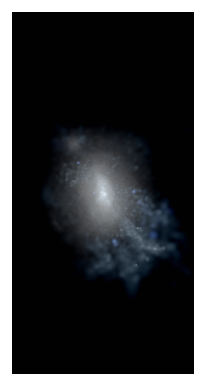

In [21]:
pixels = my_starStudio.render(plt.gca(),quick=False)
plt.gcf().set_dpi(120)
plt.gca().set_aspect( 'equal' )
plt.gcf()

## Save

### Save Figure

In [22]:
# Save plot and metadata
image_name = 'edge_on'
my_starStudio.saveFigure( plt.gca(), image_name )

### Save Metadata

In [23]:
image_name = "%s_%03d_%dkpc.hdf5" % (image_name,my_starStudio.snapnum, 2*my_starStudio.frame_half_width)
metadata_fp = os.path.join( my_starStudio.image_dir, image_name )
metadata = verdict.Dict.from_hdf5( metadata_fp, create_nonexistent=True )

In [24]:
for attr_key in [ 'Xmin', 'Xmax', 'Ymin', 'Ymax', 'Zmin', 'Zmax', 'npix_x', 'npix_y', 'pixels', 'frame_half_width', 'frame_depth' ]:
    attr = getattr( my_starStudio, attr_key )
    metadata[attr_key] = attr

In [25]:
metadata.to_hdf5( metadata_fp )
print( metadata_fp )

/scratch/03057/zhafen/hot_accretion_data/m11d_md/firestudio/Plots/GasTwoColour/edge_on_600_110kpc.hdf5


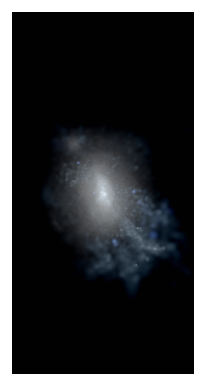

In [26]:
plt.gcf()